In [262]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
import fbprophet
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
warnings.filterwarnings("ignore")
from math import sqrt
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Exploratory Analisys and Data Manipulation

In [91]:
# importing files
IBVSP = pd.read_csv('C:/Users/joaos/Desktop/Curso Ironhack/Bootcamp_Projects/Project_12_Final-project/Datasets/BVSP.csv')
tweets = pd.read_csv('C:/Users/joaos/Desktop/Curso Ironhack/Bootcamp_Projects/Project_12_Final-project/Datasets/TweetsWithTheme.csv')

In [92]:
IBVSP.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-26,50891.0,50973.0,49914.0,50145.0,50145.0,1911100.0
1,2014-12-29,50145.0,50903.0,50008.0,50594.0,50594.0,1852500.0
2,2014-12-30,50601.0,50841.0,49993.0,50007.0,50007.0,2925300.0
3,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100.0
4,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100.0


In [93]:
IBVSP.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1.235000e+03
mean,70444.813765,71097.275304,69836.276113,70495.072874,70495.072874,3.790430e+06
std,19425.236924,19527.863223,19339.992345,19458.360011,19458.360011,1.206280e+06
min,37501.000000,38031.000000,37046.000000,37497.000000,37497.000000,0.000000e+00
25%,53052.500000,53416.500000,52638.000000,53070.500000,53070.500000,3.070600e+06
50%,66025.000000,66594.000000,65594.000000,66094.000000,66094.000000,3.653100e+06
75%,85467.500000,86108.000000,84487.500000,85489.500000,85489.500000,4.389100e+06
max,115133.000000,115863.000000,114964.000000,115863.000000,115863.000000,1.104670e+07


In [94]:
IBVSP.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [266]:
tweets.tail()

,id,tweet_text,tweet_date,sentiment,query_used,bin_variation
61586,1055096632600080384,As concorrentes estão prontas para tudo. :p Lo...,2018-10-24,Positivo,PT :),1
61587,1055204789058002949,@Frases_RCampos @vrr93 Falei de um já pensando...,2018-10-24,Positivo,governo :),1
61588,1054982223793938433,@njg00 @christophssj @pecesiqueira @cauemoura ...,2018-10-24,Positivo,governo :),1
61589,1055144918451187714,que coisa mais triste uma amiga defendendo um ...,2018-10-24,Negativo,fascista :(,-1
61590,1055068278882791425,@ElevenSports_PT @AneisCinco @putente @sitioco...,2018-10-24,Positivo,PT :),1


In [96]:
tweets.describe()

,id
count,6.159100e+04
mean,1.044464e+18
std,7.725267e+15
min,1.023702e+18
25%,1.039923e+18
50%,1.047428e+18
75%,1.049432e+18
max,1.055282e+18


In [97]:
tweets.dtypes

id             int64
tweet_text    object
tweet_date    object
sentiment     object
query_used    object
dtype: object

In [98]:
IBVSP.isnull().sum()

Date         0
Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64

In [99]:
IBVSP = IBVSP.dropna().reset_index()

In [100]:
IBVSP = IBVSP.drop('index', axis=1)

In [101]:
IBVSP['Date'] = pd.to_datetime(IBVSP['Date'])

In [102]:
IBVSP.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

#### Creating a function to label Adj close variation in 1 for positive variation and 0 for negative and no variation.

In [103]:
def turn_in_binary(x):
    variation = []
    for key, value in enumerate(x):
        if key > 0:
            if value > x.loc[key-1]:
                variation.append(1)
            elif value <= x.loc[key-1]:
                variation.append(0)
            else:
                variation.append(0)
        else:
            variation.append(0)
    return variation

In [104]:
IBVSP['day_var'] = turn_in_binary(IBVSP['Adj Close'])

In [105]:
IBVSP['day_var'].head(10)

0    0
1    1
2    0
3    0
4    0
5    1
6    1
7    1
8    0
9    0
Name: day_var, dtype: int64

#### Creating a columns with the nominal difference between two consecutive dates

In [106]:
difference = np.diff(IBVSP['Adj Close'])
difference = pd.Series(difference)
difference.index = range(1,1235,1)
IBVSP['day_diff'] = difference
IBVSP.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_var,day_diff
0,2014-12-26,50891.0,50973.0,49914.0,50145.0,50145.0,1911100.0,0,NaN
1,2014-12-29,50145.0,50903.0,50008.0,50594.0,50594.0,1852500.0,1,449.0
2,2014-12-30,50601.0,50841.0,49993.0,50007.0,50007.0,2925300.0,0,-587.0
3,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100.0,0,-1495.0
4,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100.0,0,-995.0


#### Cleaning the tweet_date column with only the necessary data and converting to datetime format

In [107]:
#cutting the IBVSP dataset to the date we are going to analise
IBVSP = IBVSP[(IBVSP.Date >= datetime(2018, 7, 29)) &
         (IBVSP.Date <= datetime(2018, 10, 25))].reset_index()

#dropping the old index column
IBVSP = IBVSP.drop(['index'], axis=1)

IBVSP.head()


,Date,Open,High,Low,Close,Adj Close,Volume,day_var,day_diff
0,2018-07-30,79866.0,80492.0,79699.0,80276.0,80276.0,2631400.0,1,410.0
1,2018-07-31,80279.0,80279.0,79016.0,79220.0,79220.0,3354500.0,0,-1056.0
2,2018-08-01,79213.0,79731.0,78769.0,79302.0,79302.0,3227100.0,1,82.0
3,2018-08-02,79237.0,79896.0,78573.0,79637.0,79637.0,3005500.0,1,335.0
4,2018-08-03,79656.0,81792.0,79656.0,81435.0,81435.0,3802600.0,1,1798.0


In [108]:
IBVSP.set_index('Date').head()

,Open,High,Low,Close,Adj Close,Volume,day_var,day_diff
Date,,,,,,,,
2018-07-30,79866.0,80492.0,79699.0,80276.0,80276.0,2631400.0,1,410.0
2018-07-31,80279.0,80279.0,79016.0,79220.0,79220.0,3354500.0,0,-1056.0
2018-08-01,79213.0,79731.0,78769.0,79302.0,79302.0,3227100.0,1,82.0
2018-08-02,79237.0,79896.0,78573.0,79637.0,79637.0,3005500.0,1,335.0
2018-08-03,79656.0,81792.0,79656.0,81435.0,81435.0,3802600.0,1,1798.0


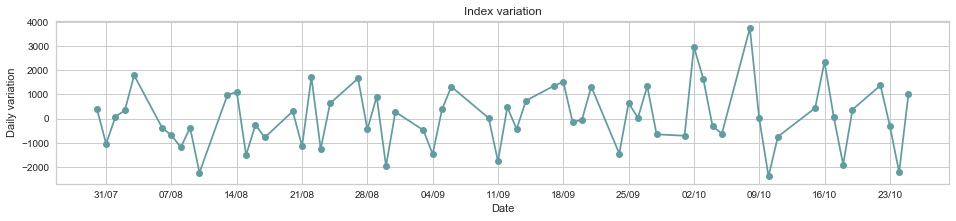

In [109]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,3))

# Add the x-axis and the y-axis to the plot
ax.plot(IBVSP['Date'].values,
        IBVSP['day_diff'], '-o',
        color='cadetblue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Daily variation",
       title="Index variation")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()

In [149]:
IBVSP['day_diff'].mean()

68.03225806451613

In [150]:
IBVSP['day_diff'].std()

1287.391058166584

#### Creating a function to label positive or negative sentiments, 1 for positive and 0 for negative variation.

In [110]:
def tweet_classification(y):
    var = []
    for key, value in enumerate(y):
        if y.loc[key] == "Positivo":
            var.append(1)
        else:
            var.append(-1)
    return var

In [111]:
tweets['bin_variation'] = tweet_classification(tweets['sentiment'])

In [112]:
tweets.head()

,id,tweet_text,tweet_date,sentiment,query_used,bin_variation
0,1026606627041026050,ela vendo a família :( FUGIDINHA VERA LÚCIA,Mon Aug 06 23:11:07 +0000 2018,Negativo,vera lucia :(,-1
1,1026266117646561281,Eu odeio o fato que muito provavelmente meu vo...,Mon Aug 06 00:38:04 +0000 2018,Negativo,ciro :(,-1
2,1025889796097564672,"Ciro ""mita"" tanto quanto aquele outro, não que...",Sat Aug 04 23:42:42 +0000 2018,Negativo,ciro :(,-1
3,1026960047937646598,Raiva do Bolsonaro agora :),Tue Aug 07 22:35:30 +0000 2018,Positivo,bolsonaro :),1
4,1026447105932623872,Reflexos da alienação petista comandada por Lu...,Mon Aug 06 12:37:15 +0000 2018,Negativo,lula :(,-1


In [113]:
# cleaning the date column
tweets['tweet_date'] = tweets['tweet_date'].str[4:10] + " " + "2018"

In [114]:
tweets['tweet_date']= pd.to_datetime(tweets['tweet_date']) 

In [115]:
tweets['tweet_date'] = tweets['tweet_date'].dt.strftime('%Y-%m-%d')

In [116]:
tweets.head()

,id,tweet_text,tweet_date,sentiment,query_used,bin_variation
0,1026606627041026050,ela vendo a família :( FUGIDINHA VERA LÚCIA,2018-08-06,Negativo,vera lucia :(,-1
1,1026266117646561281,Eu odeio o fato que muito provavelmente meu vo...,2018-08-06,Negativo,ciro :(,-1
2,1025889796097564672,"Ciro ""mita"" tanto quanto aquele outro, não que...",2018-08-04,Negativo,ciro :(,-1
3,1026960047937646598,Raiva do Bolsonaro agora :),2018-08-07,Positivo,bolsonaro :),1
4,1026447105932623872,Reflexos da alienação petista comandada por Lu...,2018-08-06,Negativo,lula :(,-1


#### Creating a new datatable with data from IBVSP and tweets

In [117]:
#creating a new dataset with the sum of the daily positive and negative sentiments from with tweets
tweets_IBVSP = tweets.groupby(['tweet_date'])['bin_variation'].sum().to_frame('bin_variation').reset_index()

In [118]:
tweets_IBVSP.head()

,tweet_date,bin_variation
0,2018-07-29,-1
1,2018-07-30,35
2,2018-07-31,79
3,2018-08-01,-1
4,2018-08-02,44


In [119]:
tweets_IBVSP = tweets_IBVSP.rename(columns={'bin_variation': 'sum_sentiment'})

In [120]:
tweets_IBVSP['tweet_date']= pd.to_datetime(tweets_IBVSP['tweet_date']) 

In [121]:
tweets_IBVSP.columns

Index(['tweet_date', 'sum_sentiment'], dtype='object')

In [122]:
tweets_IBVSP.head()

,tweet_date,sum_sentiment
0,2018-07-29,-1
1,2018-07-30,35
2,2018-07-31,79
3,2018-08-01,-1
4,2018-08-02,44


In [123]:
tweets_IBVSP.describe()

,sum_sentiment
count,89.000000
mean,43.786517
std,288.001242
min,-2270.000000
25%,37.000000
50%,88.000000
75%,127.000000
max,250.000000


###### As we can see we have a great difference between the min and max values, indicating possibles outliers. Lets plot the series:

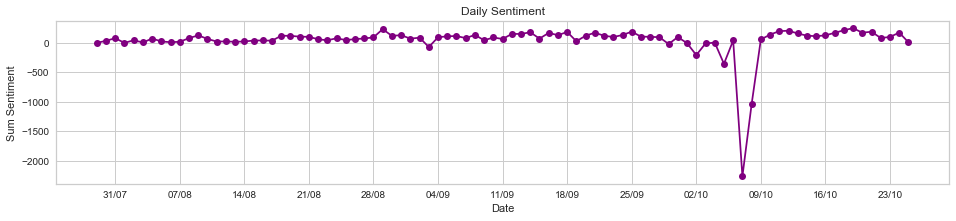

In [124]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,3))

# Add the x-axis and the y-axis to the plot
ax.plot(tweets_IBVSP['tweet_date'].values,
        tweets_IBVSP['sum_sentiment'], '-o',
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Sum Sentiment",
       title="Daily Sentiment")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()

#### As we can see there are a huge negative variation in the days after the election day in Brazil. To avoid any problem, lets remove these outliers

In [125]:
tweets_IBVSP = tweets_IBVSP[~tweets_IBVSP['tweet_date'].isin([pd.Timestamp('2018-10-08'), pd.Timestamp('2018-10-07'), pd.Timestamp('2018-10-05'), pd.Timestamp('2018-10-02')])]

In [126]:
#tweets_IBVSP = tweets_IBVSP[tweets_IBVSP['tweet_date']] != '2018-10-07'

In [127]:
#tweets_IBVSP = tweets_IBVSP[tweets_IBVSP['tweet_date']] != '2018-10-08']

In [128]:
#tweets_IBVSP = tweets_IBVSP[tweets_IBVSP['tweet_date']] != '2018-10-05']

In [129]:
#tweets_IBVSP = tweets_IBVSP[tweets_IBVSP['tweet_date']] != '2018-10-02']

In [130]:
tweets_IBVSP.reset_index().head()

,index,tweet_date,sum_sentiment
0,0,2018-07-29,-1
1,1,2018-07-30,35
2,2,2018-07-31,79
3,3,2018-08-01,-1
4,4,2018-08-02,44


##### Plotting the graph again:

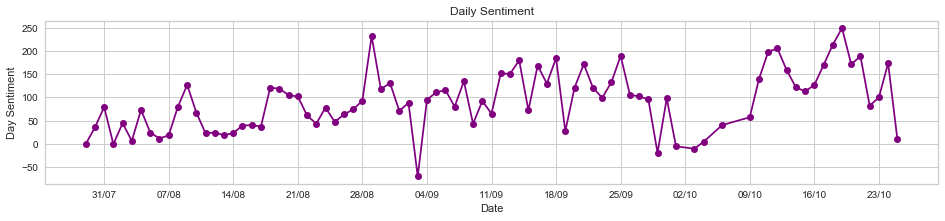

In [131]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,3))

# Add the x-axis and the y-axis to the plot
ax.plot(tweets_IBVSP['tweet_date'].values,
        tweets_IBVSP['sum_sentiment'], '-o',
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Day Sentiment",
       title="Daily Sentiment")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()

In [153]:
tweets_IBVSP['sum_sentiment'].describe()

count     85.000000
mean      91.447059
std       64.576368
min      -71.000000
25%       40.000000
50%       93.000000
75%      130.000000
max      250.000000
Name: sum_sentiment, dtype: float64

In [132]:
# Setting tweet date as index:
tweets_IBVSP = tweets_IBVSP.set_index('tweet_date')


In [133]:
tweets_IBVSP.head()

,sum_sentiment
tweet_date,
2018-07-29,-1
2018-07-30,35
2018-07-31,79
2018-08-01,-1
2018-08-02,44


# Normalization

#### For some statistics methods its important to normalize the data, in this project we are going to use Min Max Scaler and Standard Scaler:

#### Min Max Scaler

In [134]:
### IBVSP

# Create x, where x the 'scores' column's values as floats
x = IBVSP[['day_diff']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)

In [135]:
IBVSP['diff_normalized_mms']= df_normalized

In [136]:
print('Mean: %f, StandardDeviation: %f' % (IBVSP['diff_normalized_mms'].mean(), IBVSP['diff_normalized_mms'].std()))

Mean: 0.401399, StandardDeviation: 0.208620


In [137]:
IBVSP.head()

,Date,Open,High,Low,Close,Adj Close,Volume,day_var,day_diff,diff_normalized_mms
0,2018-07-30,79866.0,80492.0,79699.0,80276.0,80276.0,2631400.0,1,410.0,0.456814
1,2018-07-31,80279.0,80279.0,79016.0,79220.0,79220.0,3354500.0,0,-1056.0,0.219251
2,2018-08-01,79213.0,79731.0,78769.0,79302.0,79302.0,3227100.0,1,82.0,0.403662
3,2018-08-02,79237.0,79896.0,78573.0,79637.0,79637.0,3005500.0,1,335.0,0.444661
4,2018-08-03,79656.0,81792.0,79656.0,81435.0,81435.0,3802600.0,1,1798.0,0.681737


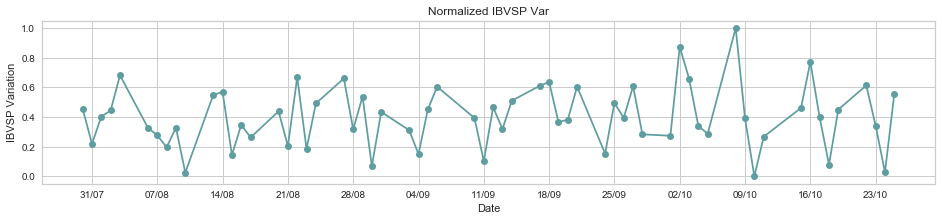

In [156]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,3))

# Add the x-axis and the y-axis to the plot
ax.plot(IBVSP['Date'].values,
        IBVSP['diff_normalized_mms'], '-o',
        color='cadetblue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="IBVSP Variation",
       title="Normalized IBVSP Var")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()

In [157]:
### tweets

# Create x, where x the 'scores' column's values as floats
y = tweets_IBVSP[['sum_sentiment']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
y_scaled = min_max_scaler.fit_transform(y)

# Run the normalizer on the dataframe
df_normalized_2 = pd.DataFrame(y_scaled)

In [158]:
df_normalized_2 = df_normalized_2.set_index(tweets_IBVSP.index)

In [159]:
tweets_IBVSP['sum_sentiment_mms'] = df_normalized_2.iloc[:,0].values

In [160]:
tweets_IBVSP = tweets_IBVSP.reset_index()

In [161]:
print('Mean: %f, StandardDeviation: %f' % (tweets_IBVSP['sum_sentiment_mms'].mean(), tweets_IBVSP['sum_sentiment_mms'].std()))

Mean: 0.506066, StandardDeviation: 0.201172


In [162]:
tweets_IBVSP.columns

Index(['index', 'tweet_date', 'sum_sentiment', 'sum_sentiment_mms'], dtype='object')

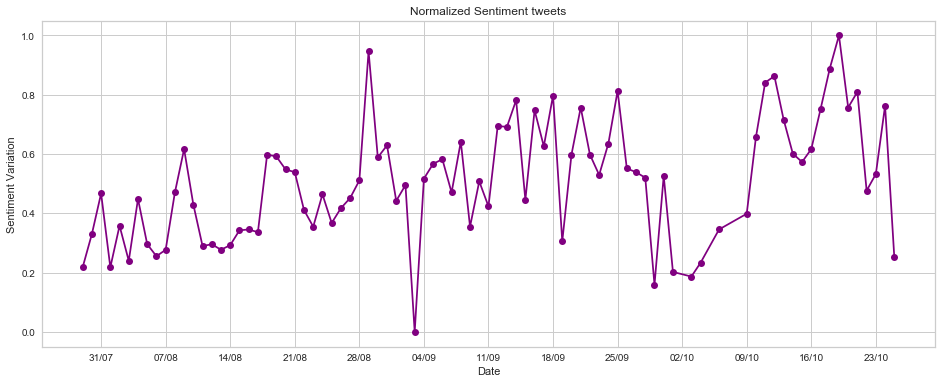

In [163]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,6))

# Add the x-axis and the y-axis to the plot
ax.plot(tweets_IBVSP['tweet_date'].values,
        tweets_IBVSP['sum_sentiment_mms'], '-o',
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Sentiment Variation",
       title="Normalized Sentiment tweets")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()


### StandardScaler

In [164]:
# prepare data for standardization
values = IBVSP['day_diff'].values
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
df_normalized_3 = scaler.transform(values)

Mean: 68.032258, StandardDeviation: 1276.966668


In [165]:
IBVSP['diff_normalized_SS'] =  pd.DataFrame({'day_diff_SS': df_normalized_3[:, 0]})

In [190]:
IBVSP['diff_normalized_SS'].mean()

2.686023446673766e-17

In [191]:
IBVSP['diff_normalized_SS'].std()

1.0081634007555278

In [166]:
IBVSP.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,day_var,day_diff,diff_normalized_mms,diff_normalized_SS
57,2018-10-19,83845.0,84954.0,83667.0,84220.0,84220.0,3753500.0,1,373.0,0.450818,0.238822
58,2018-10-22,84222.0,85772.0,84222.0,85597.0,85597.0,3873700.0,1,1377.0,0.613515,1.025060
59,2018-10-23,85595.0,85595.0,84032.0,85300.0,85300.0,4388100.0,0,-297.0,0.342246,-0.285859
60,2018-10-24,85302.0,85786.0,83035.0,83064.0,83064.0,4679200.0,0,-2236.0,0.028034,-1.804301
61,2018-10-25,83124.0,84831.0,83124.0,84084.0,84084.0,0.0,1,1020.0,0.555664,0.745491


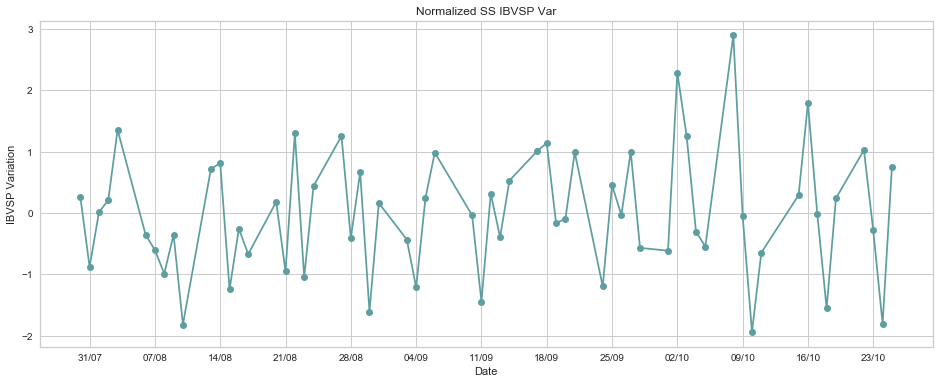

In [168]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,6))

# Add the x-axis and the y-axis to the plot
ax.plot(IBVSP['Date'].values,
        IBVSP['diff_normalized_SS'], '-o',
        color='cadetblue')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="IBVSP Variation",
       title="Normalized SS IBVSP Var")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()

In [169]:
## Tweets

# prepare data for standardization
values = tweets_IBVSP['sum_sentiment'].values
values = values.reshape((len(values), 1))
# train the standardization
scaler2 = StandardScaler()
scaler2 = scaler2.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler2.mean_, sqrt(scaler2.var_)))
# standardization the dataset and print the first 5 rows
df_normalized_4 = scaler2.transform(values)

Mean: 91.447059, StandardDeviation: 64.195383


In [170]:
tweets_IBVSP['sum_sentiment_SS'] =  pd.DataFrame({'sum_sentiment_SS': df_normalized_4[:, 0]})

In [192]:
tweets_IBVSP['sum_sentiment_SS'].mean()

-8.098097356089377e-17

In [193]:
tweets_IBVSP['sum_sentiment_SS'].std()

1.0059347702036958

In [171]:
tweets_IBVSP.tail()

,index,tweet_date,sum_sentiment,sum_sentiment_mms,sum_sentiment_SS
80,80,2018-10-21,189,0.809969,1.519626
81,81,2018-10-22,82,0.476636,-0.147161
82,82,2018-10-23,100,0.532710,0.133233
83,83,2018-10-24,174,0.763240,1.285964
84,84,2018-10-25,10,0.252336,-1.268737


In [172]:
tweets_IBVSP.dtypes

index                         int64
tweet_date           datetime64[ns]
sum_sentiment                 int64
sum_sentiment_mms           float64
sum_sentiment_SS            float64
dtype: object

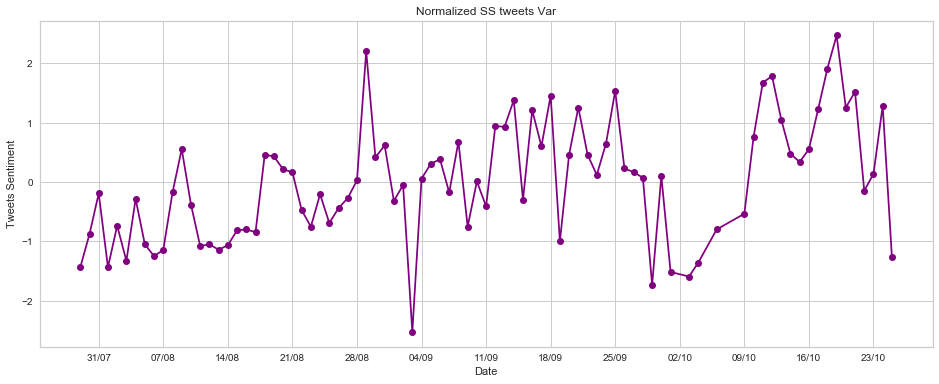

In [173]:
# Create the plot space upon which to plot the data
fig, ax = plt.subplots(figsize=(16,6))

# Add the x-axis and the y-axis to the plot
ax.plot(tweets_IBVSP['tweet_date'].values,
        tweets_IBVSP['sum_sentiment_SS'], '-o',
        color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Tweets Sentiment",
       title="Normalized SS tweets Var")

# Clean up the x axis dates 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d/%m"))

plt.show()

##### Adding columns from IBVSP to tweets_IBVSP

In [174]:
tweets_IBVSP['Day_Var_IBVSP'] = tweets_IBVSP['tweet_date'].map(IBVSP.set_index('Date')['day_var'])

In [175]:
tweets_IBVSP['day_diff_IBVSP'] = tweets_IBVSP['tweet_date'].map(IBVSP.set_index('Date')['day_diff'])

In [176]:
tweets_IBVSP['normalized_mms_IBVSP'] = tweets_IBVSP['tweet_date'].map(IBVSP.set_index('Date')['diff_normalized_mms'])

In [177]:
tweets_IBVSP['normalized_SS_IBVSP'] = tweets_IBVSP['tweet_date'].map(IBVSP.set_index('Date')['diff_normalized_SS'])

In [178]:
tweets_IBVSP.head()

,index,tweet_date,sum_sentiment,sum_sentiment_mms,sum_sentiment_SS,Day_Var_IBVSP,day_diff_IBVSP,normalized_mms_IBVSP,normalized_SS_IBVSP
0,0,2018-07-29,-1,0.218069,-1.440089,NaN,NaN,NaN,NaN
1,1,2018-07-30,35,0.330218,-0.879301,1.0,410.0,0.456814,0.267797
2,2,2018-07-31,79,0.467290,-0.193893,0.0,-1056.0,0.219251,-0.880236
3,3,2018-08-01,-1,0.218069,-1.440089,1.0,82.0,0.403662,0.010938
4,4,2018-08-02,44,0.358255,-0.739104,1.0,335.0,0.444661,0.209064


In [179]:
tweets_IBVSP2 = tweets_IBVSP.fillna(method='bfill')

In [180]:
tweets_IBVSP2.head(10)

,index,tweet_date,sum_sentiment,sum_sentiment_mms,sum_sentiment_SS,Day_Var_IBVSP,day_diff_IBVSP,normalized_mms_IBVSP,normalized_SS_IBVSP
0,0,2018-07-29,-1,0.218069,-1.440089,1.0,410.0,0.456814,0.267797
1,1,2018-07-30,35,0.330218,-0.879301,1.0,410.0,0.456814,0.267797
2,2,2018-07-31,79,0.467290,-0.193893,0.0,-1056.0,0.219251,-0.880236
3,3,2018-08-01,-1,0.218069,-1.440089,1.0,82.0,0.403662,0.010938
4,4,2018-08-02,44,0.358255,-0.739104,1.0,335.0,0.444661,0.209064
5,5,2018-08-03,6,0.239875,-1.331047,1.0,1798.0,0.681737,1.354748
6,6,2018-08-04,73,0.448598,-0.287358,0.0,-384.0,0.328148,-0.353989
7,7,2018-08-05,24,0.295950,-1.050653,0.0,-384.0,0.328148,-0.353989
8,8,2018-08-06,11,0.255452,-1.253160,0.0,-384.0,0.328148,-0.353989
9,9,2018-08-07,18,0.277259,-1.144117,0.0,-704.0,0.276292,-0.604583


In [181]:
tweets_IBVSP2['Date'] = tweets_IBVSP2['tweet_date']

In [182]:
tweets_IBVSP2.set_index('tweet_date', inplace=True)

##### Comparing the two types of normalization

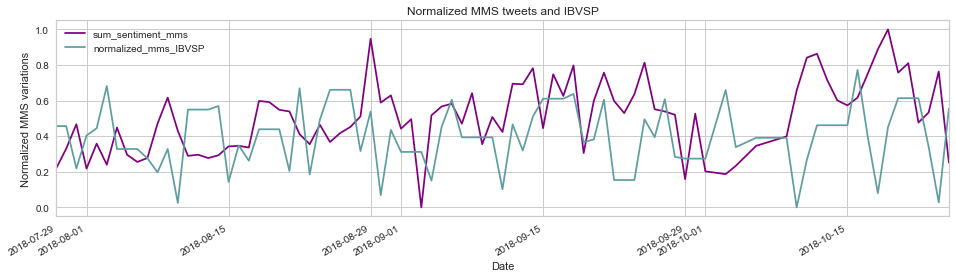

In [186]:
ax = plt.gca()

tweets_IBVSP2.plot(kind='line',x='Date',y='sum_sentiment_mms', color='purple', figsize=(16,4),ax=ax), '-o',
tweets_IBVSP2.plot(kind='line',x='Date',y='normalized_mms_IBVSP', color='cadetblue', figsize=(16,4), ax=ax), '-o',

ax.set(xlabel="Date",
       ylabel="Normalized MMS variations",
       title="Normalized MMS tweets and IBVSP")


plt.show()

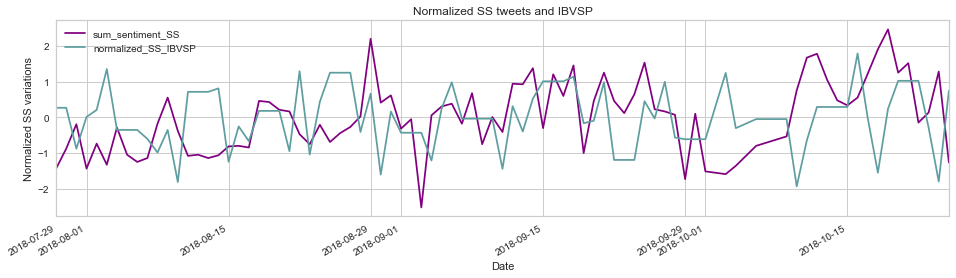

In [194]:
ax = plt.gca()

tweets_IBVSP2.plot(kind='line',x='Date',y='sum_sentiment_SS', color='purple', figsize=(16,4), ax=ax)
tweets_IBVSP2.plot(kind='line',x='Date',y='normalized_SS_IBVSP', color='cadetblue', figsize=(16,4), ax=ax)

ax.set(xlabel="Date",
       ylabel="Normalized SS variations",
       title="Normalized SS tweets and IBVSP")


plt.show()

In [195]:
tweets_IBVSP2.columns

Index(['index', 'sum_sentiment', 'sum_sentiment_mms', 'sum_sentiment_SS',
       'Day_Var_IBVSP', 'day_diff_IBVSP', 'normalized_mms_IBVSP',
       'normalized_SS_IBVSP', 'Date'],
      dtype='object')

### Splitting trainning and test datasets

In [196]:
X = tweets_IBVSP2.values
train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 85
Training Observations: 59
Testing Observations: 26


#### Linear Regression with MMS

In [233]:
X = tweets_IBVSP2.sum_sentiment_mms.values.reshape(-1,1)
y = tweets_IBVSP2.normalized_mms_IBVSP.values.reshape(-1,1)

In [234]:
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits = 2)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=3)


In [235]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [236]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[0.34373252]
[[0.11081916]]


In [237]:
regressor.score(X_train, y_train)

0.01354643170676506

In [238]:
y_pred = regressor.predict(X_test)

In [239]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

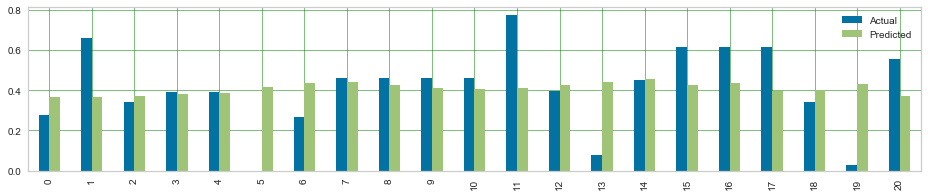

In [240]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,3))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

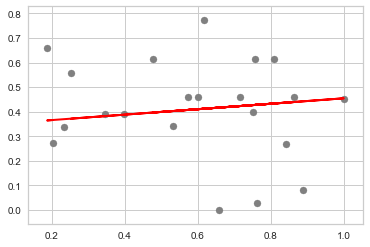

In [241]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

0.01354643170676506

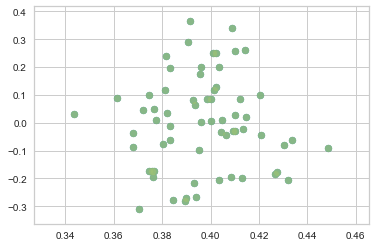

In [206]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(regressor, hist=False)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_train, y_train)  

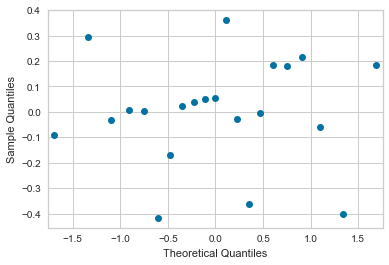

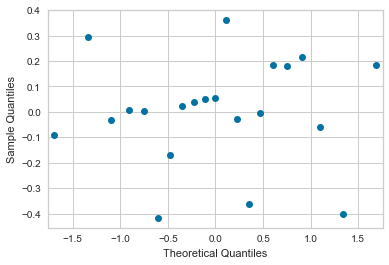

In [207]:
import statsmodels.api as sm

predictions = regressor.predict(X_test)
residuals = y_test - predictions
sm.qqplot(residuals)

#### Linear Regression with SS

In [208]:
X1 = tweets_IBVSP2.sum_sentiment_SS.values.reshape(-1,1)
y1 = tweets_IBVSP2.normalized_SS_IBVSP.values.reshape(-1,1)

In [209]:
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits = 2)
for train_index, test_index in tscv.split(X1):
    X1_train, X1_test = X1[train_index], X1[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=3)


In [210]:
regressor = LinearRegression()  
regressor.fit(X1_train, y1_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [221]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[-0.00765747]
[[0.10710003]]


In [222]:
regressor.score(X1_train, y1_train)

0.01354643170676517

In [223]:
y1_pred = regressor.predict(X1_test)

In [224]:
df2 = pd.DataFrame({'Actual': y1_test.flatten(), 'Predicted': y1_pred.flatten()})

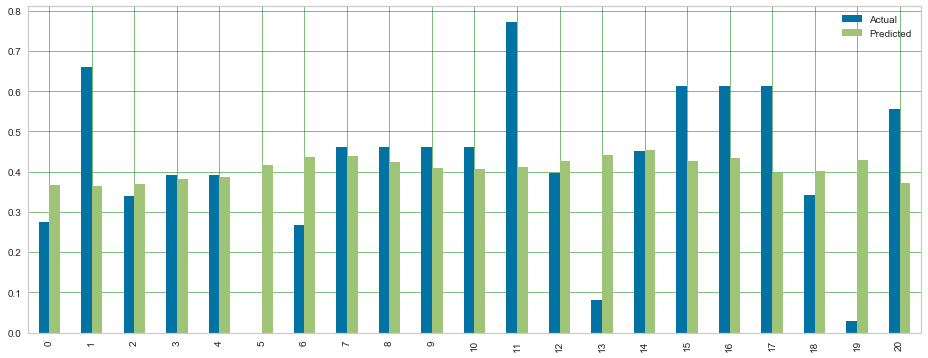

In [225]:
df2 = df.head(25)
df1.plot(kind='bar',figsize=(16,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

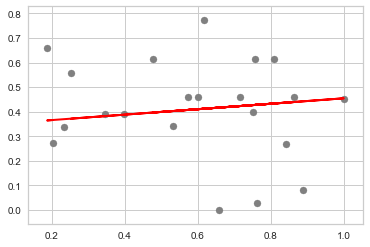

In [226]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

0.01354643170676517

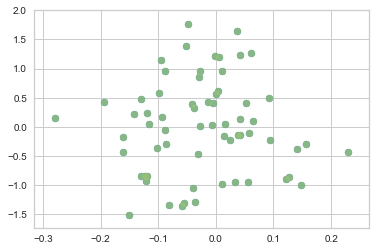

In [227]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(regressor, hist=False)
visualizer.fit(X1_train, y1_train)  # Fit the training data to the model
visualizer.score(X1_train, y1_train)  

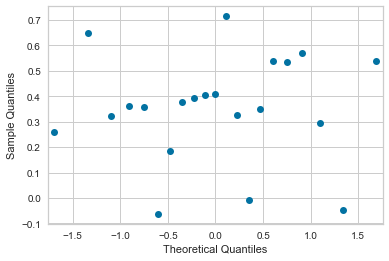

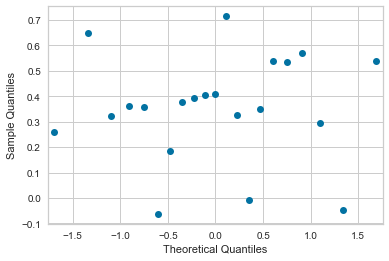

In [228]:
import statsmodels.api as sm

predictions = regressor.predict(X_test)
residuals = y_test - predictions
sm.qqplot(residuals)

#### Logistic Regression

In [242]:
X2 = tweets_IBVSP2.sum_sentiment.values.reshape(-1,1)
y2 = tweets_IBVSP2.Day_Var_IBVSP.values.reshape(-1,1)

In [243]:
tscv2 = TimeSeriesSplit()
print(tscv2)
TimeSeriesSplit(max_train_size=None, n_splits = 2)
for train_index, test_index in tscv.split(X2):
    X2_train, X2_test = X2[train_index], X2[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=3)


In [244]:
ks_model = LogisticRegression().fit(X2_train, y2_train)

In [245]:
ks_model.score(X2_train, y2_train)

0.53125

In [246]:
y_pred = ks_model.predict(X2_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(ks_model.score(X2_test, y2_test)))

Accuracy of logistic regression classifier on test set: 0.62


In [276]:
ks_model.predict_proba(x)[:,1].max()

0.9999999999906386

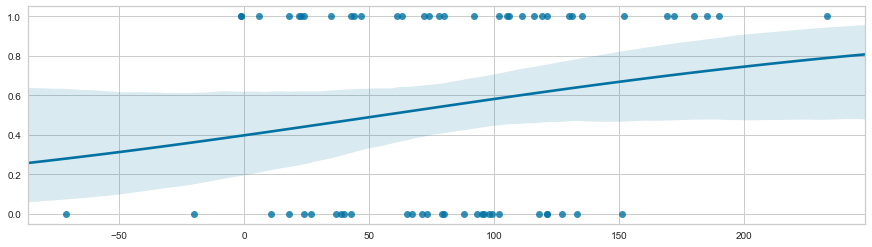

In [275]:
plt.figure(figsize=(15,4))

sns.regplot(x=X2_train, y=y2_train, data=tweets_IBVSP2, logistic=True)

0.9999999999906386

In [265]:
cm=confusion_matrix(y2_test, y_pred)
print(cm)

[[ 2  5]
 [ 3 11]]


# PROPHET

In [105]:
tweets_IBVSP2.dtypes

sum_sentiment                    int64
sum_sentiment_mms              float64
sum_sentiment_SS               float64
Day_Var_IBVSP                  float64
day_diff_IBVSP                 float64
normalized_mms_IBVSP           float64
normalized_SS_IBVSP            float64
Date                    datetime64[ns]
dtype: object

### MMS

In [106]:
tweets_IBVSP2_pbt = tweets_IBVSP2

In [107]:
tweets_IBVSP2_pbt['ds'] = tweets_IBVSP2_pbt['Date']
tweets_IBVSP2_pbt['y'] = tweets_IBVSP2_pbt['normalized_mms_IBVSP']

In [108]:
m = fbprophet.Prophet()

In [109]:
m.fit(tweets_IBVSP2_pbt)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
future = m.make_future_dataframe(periods=7)

In [111]:
forecast = m.predict(future)

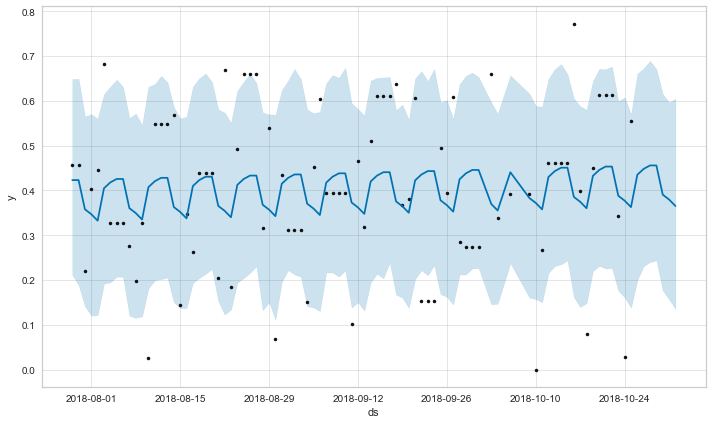

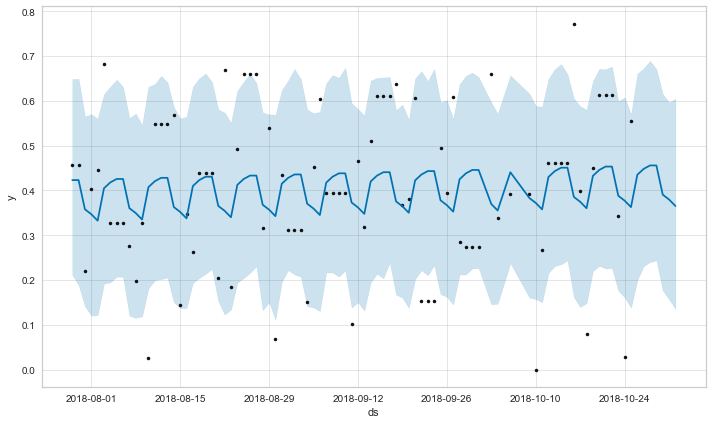

In [112]:
m.plot(forecast)

### SS

In [113]:
tweets_IBVSP2_pbt2 = tweets_IBVSP2

In [114]:
tweets_IBVSP2_pbt2['ds'] = tweets_IBVSP2_pbt2['Date']
tweets_IBVSP2_pbt2['y'] = tweets_IBVSP2_pbt2['normalized_SS_IBVSP']

In [115]:
m2 = fbprophet.Prophet()

In [116]:
m2.fit(tweets_IBVSP2_pbt2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
future = m2.make_future_dataframe(periods=7)

In [118]:
forecast = m2.predict(future)

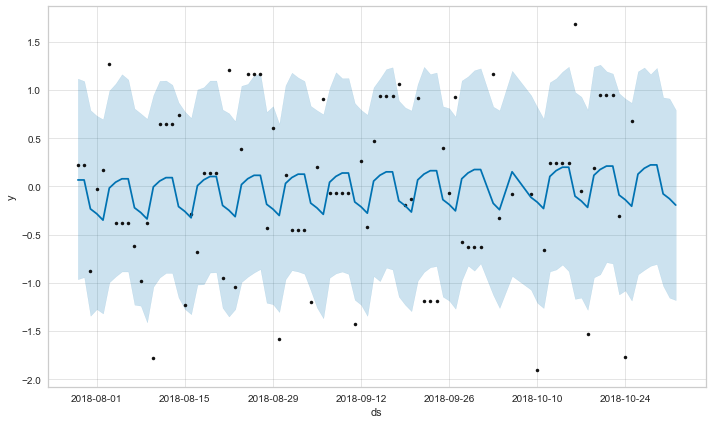

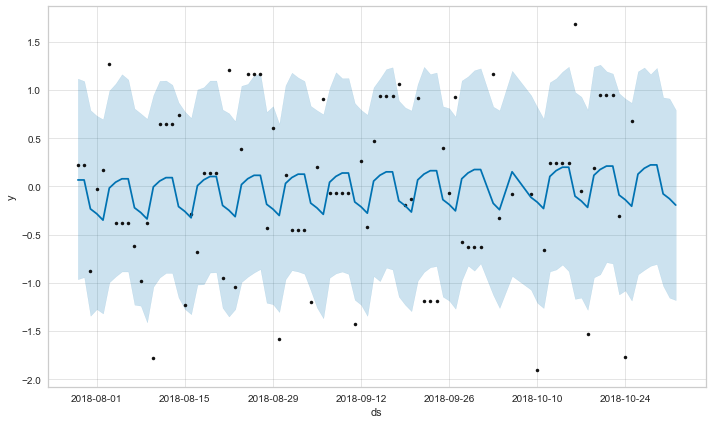

In [119]:
m2.plot(forecast)

# ARIMA

### Split the data into train/test sets

In [120]:
train = tweets_IBVSP2.iloc[:80]
test = tweets_IBVSP2.iloc[80:]

In [121]:
model = ARIMA(train['day_diff_IBVSP'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.day_diff_IBVSP   No. Observations:                   79
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -664.502
Method:                       css-mle   S.D. of innovations           1060.179
Date:                Mon, 20 Jan 2020   AIC                           1337.005
Time:                        23:49:48   BIC                           1346.483
Sample:                             1   HQIC                          1340.802
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.3488      5.773      0.234      0.816      -9.967      12.664
ar.L1.D.day_diff_IBVSP     0.1151      0.113      1.016      0.313      -0.107       0.337
ma.L1.D.day_diff_IBVSP    -1.0000      0.034    -29.439      0.000      -1.067      -0.933
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            8.6907           +0.0000j            8.6907            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [122]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [126]:
pd.plotting.register_matplotlib_converters()

In [132]:
model = ARIMA(tweets_IBVSP2['day_diff_IBVSP'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

NameError: name 'formatter' is not defined

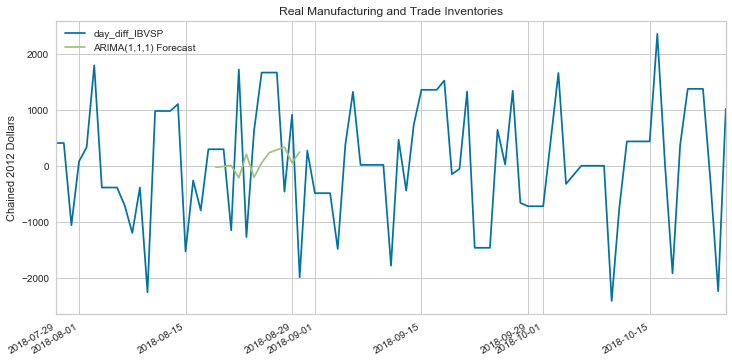

In [133]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = tweets_IBVSP2['day_diff_IBVSP'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);